In [50]:
# Downlod train from https://www.kaggle.com/c/dogs-vs-cats/data?select=train.zip
# This dropbox url could die somewhen

#!wget -nc "https://www.dropbox.com/s/ae1lq6dsfanse76/dogs_vs_cats.train.zip?dl=1" -O data/dogs_vs_cats.train.zip

In [48]:
#!unzip -n data/dogs_vs_cats.train.zip

In [51]:
# see train folder. It's cats dataset
!ls 

data	      images		  mnist.ipynb	    train
features.npy  image_search.ipynb  requirements.txt  venv


In [52]:
import requests

# class labels
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
labels = {int(key):value for (key, value) in requests.get(LABELS_URL).json().items()}

In [55]:
from torchvision.models.resnet import resnet50

model = resnet50(pretrained=True,progress=True)
model.train(False)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [56]:
import torch

# Просто проверим что все работает

dummy_x = torch.randn(5, 3, 224, 224)
model(dummy_x)

tensor([[-0.7606,  0.2625, -0.3600,  ..., -2.5140, -0.9401,  1.1363],
        [-0.7046,  0.2337, -0.1040,  ..., -2.6959, -1.0619,  1.2730],
        [-0.7353,  0.1905, -0.1611,  ..., -2.3988, -0.8878,  1.3097],
        [-0.7749,  0.0828,  0.0785,  ..., -2.5131, -0.9012,  1.5511],
        [-0.7552,  0.4457,  0.0509,  ..., -2.5330, -0.9071,  1.4121]],
       grad_fn=<AddmmBackward>)

In [54]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np
from torchvision import transforms

transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def load_img(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

def transform_input(img):
    return transform(img).unsqueeze(0)

def predict(img):
    img = transform_input(img)
    
    prediction = model(img)
    probs = torch.nn.functional.softmax(prediction, dim=-1)
    probs = probs.data.numpy()
    
    top_ix = probs.ravel().argsort()[-1:-10:-1]
    print ('top-10 classes are: \n [prob : class label]')
    for l in top_ix:
        print ('{:.4f} :\t{}'.format(probs.ravel()[l], labels[l].split(',')[0]))

top-10 classes are: 
 [prob : class label]
0.9860 :	drake
0.0133 :	goose
0.0003 :	red-breasted merganser
0.0001 :	partridge
0.0000 :	black swan
0.0000 :	European gallinule
0.0000 :	ruffed grouse
0.0000 :	American coot
0.0000 :	peacock
None


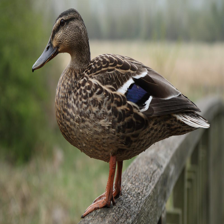

In [57]:
img = load_img('https://cms.qz.com/wp-content/uploads/2016/10/2427770107_e7be35d768_o-e1475851811724.jpg?quality=75&strip=all&w=1600&h=900&crop=1')

print(predict(img))

img.resize(size=(224,224))

top-10 classes are: 
 [prob : class label]
0.6526 :	suit
0.2202 :	Windsor tie
0.0539 :	groom
0.0105 :	bow tie
0.0084 :	bolo tie
0.0028 :	oboe
0.0019 :	cornet
0.0018 :	Loafer
0.0018 :	notebook
None


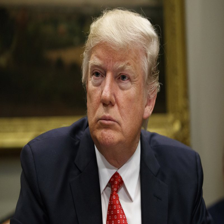

In [7]:
img = load_img('http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg')

print(predict(img))

img.resize(size=(224,224))

Заменим последний слой нейросети на "Ничего"

In [8]:
del model

In [9]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x
        
    
# redefine the last layer to be Identity


embedding = resnet50(pretrained=True, progress=True)
embedding.fc = Identity()

assert embedding(transform_input(img)).data.numpy().shape == (1, 2048), "your output for single image should have shape (1, 2048)"

embedding.train(False)
embedding = embedding.cuda()

In [39]:
#extract features from images
from tqdm.notebook import tqdm
import PIL.Image as Image
import os
import numpy as np


X = []
Y = []

batch_size = 64
batch_index = 0

imgs = torch.zeros([batch_size, 3, 224, 224])
files = os.listdir('train')

for fname in tqdm(files):
    y = fname.startswith("cat")
    Y.append(y)
    
    img = Image.open(os.path.join("train", fname))
    imgs[batch_index] = transform(img)
    
    if batch_index == batch_size - 1:
        features = embedding(imgs.cuda()).detach().cpu().numpy()
        
        X.append(features)
        
        batch_index = 0
        continue
        
    batch_index += 1

In [40]:
# stack all features
X = np.concatenate(X)

#crop if we ended prematurely
Y = np.array(Y[:len(X)])

print(X.shape, Y.shape)

(24960, 2048) (24960,)


In [41]:
np.save('features.npy', X)

In [42]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(metric = 'euclidean')
nn.fit(X)

NearestNeighbors(metric='euclidean')

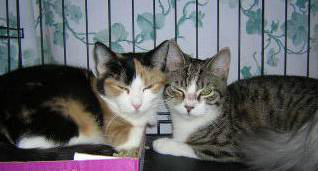

In [59]:
i = 42
Image.open(os.path.join('train', files[i]))

In [60]:
from IPython.display import Image as ImageD
from IPython.display import display

def search_similar(url):
    img = load_img(url)
    input_tensor = transform_input(img).cuda()
    
    features = embedding(input_tensor).detach().cpu().numpy()
    
    pred = nn.kneighbors(features.reshape(1,-1), n_neighbors=5)
    ids = pred[1].reshape(-1)

    display(ImageD(url=url))
    for j in ids:
        file = os.path.join("train", files[j])
        display(ImageD(file))

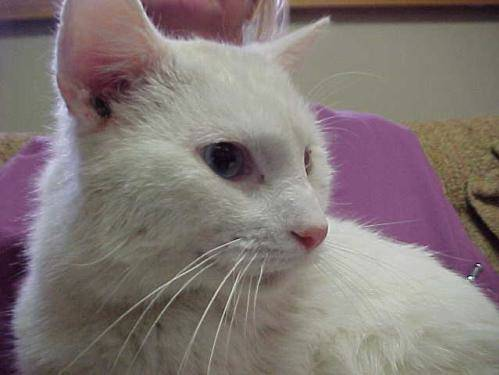

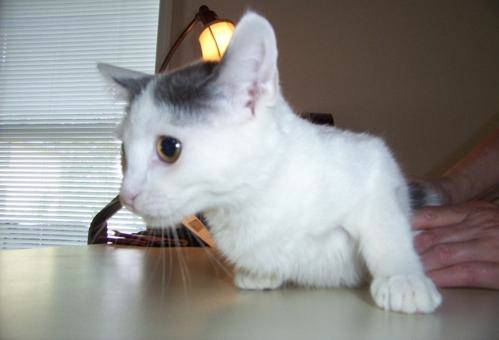

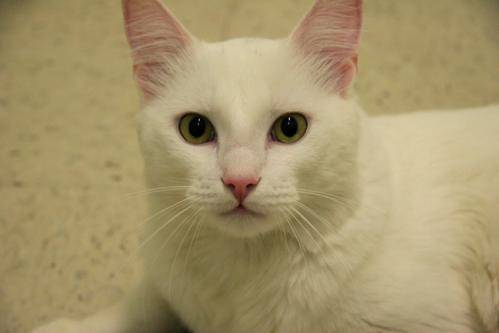

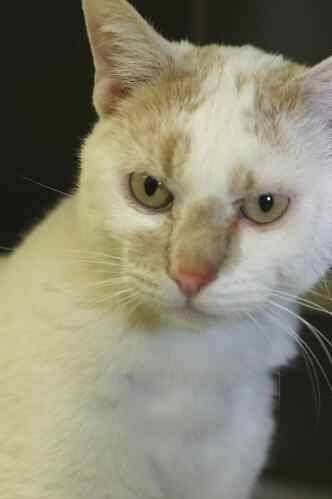

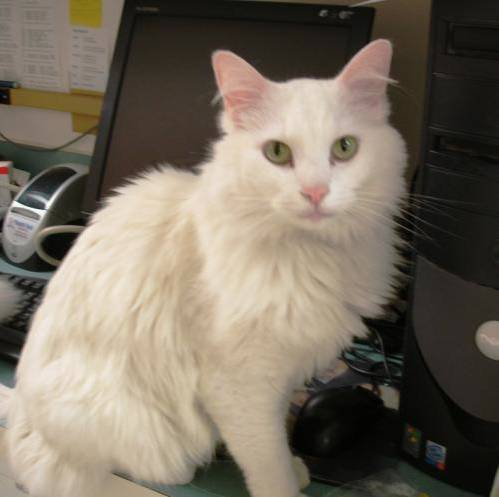

In [61]:
search_similar('https://memepedia.ru/wp-content/uploads/2018/08/serious_cat.jpg')

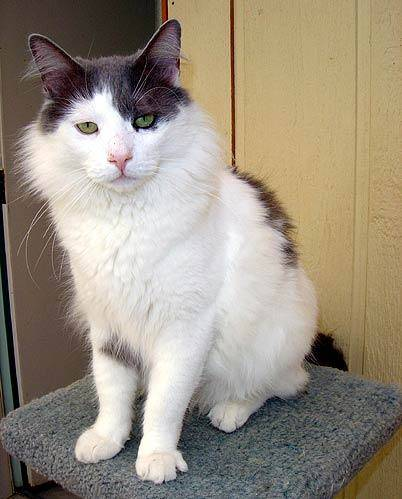

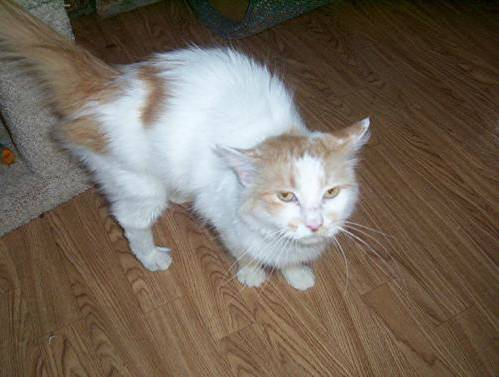

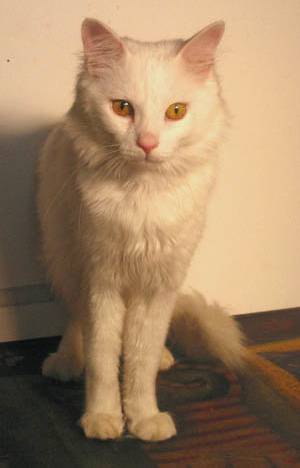

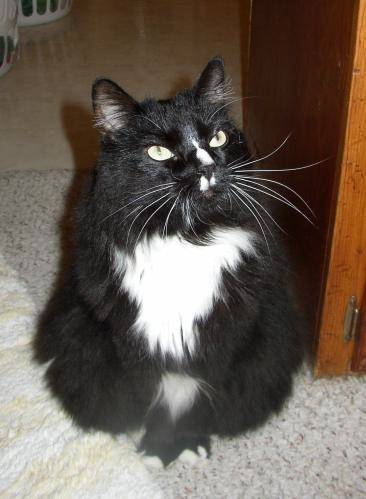

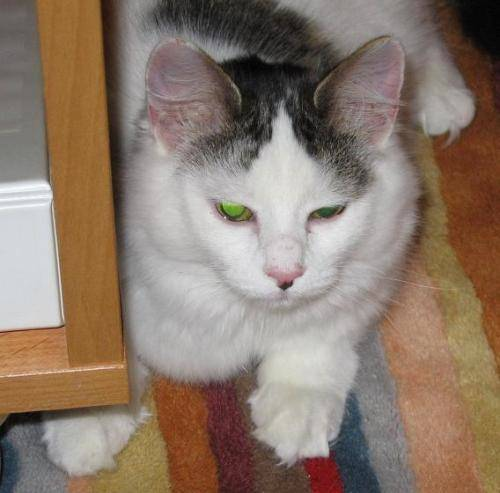

In [62]:
search_similar('https://cdn1.telegram.one/i/875f61780916f9131e7984cdc8f6e8ce/f629ed9325990b10543ab5946c1362fb/66b2dbdbe2e68ab8e51b5af3d6e360ae.jpg')

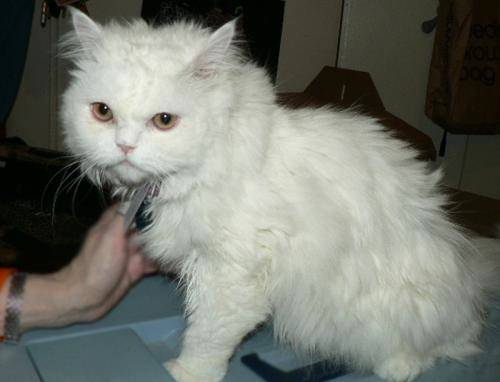

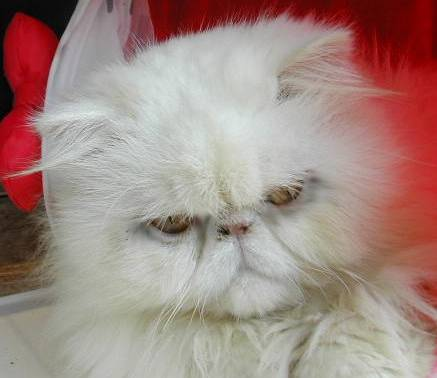

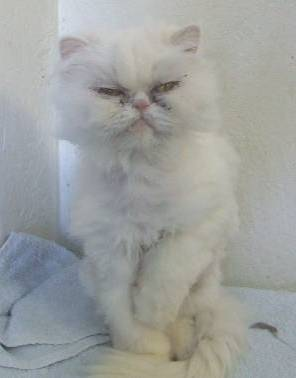

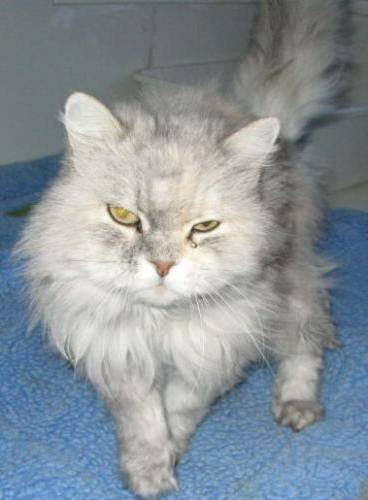

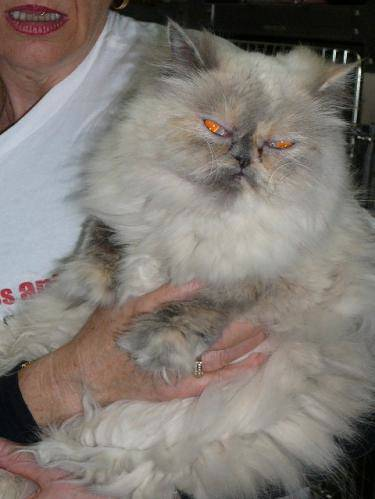

In [63]:
search_similar('https://i.pinimg.com/originals/26/d5/f8/26d5f887afaea4e93014b7dc4841d2b7.jpg')

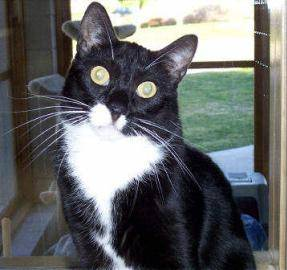

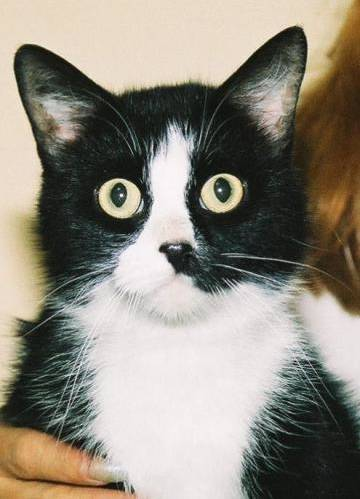

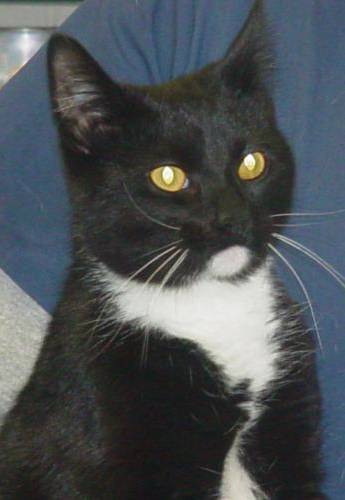

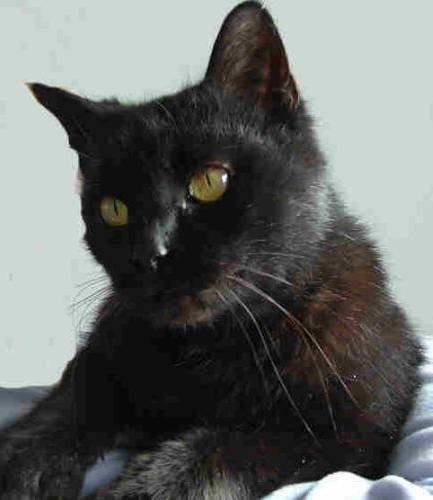

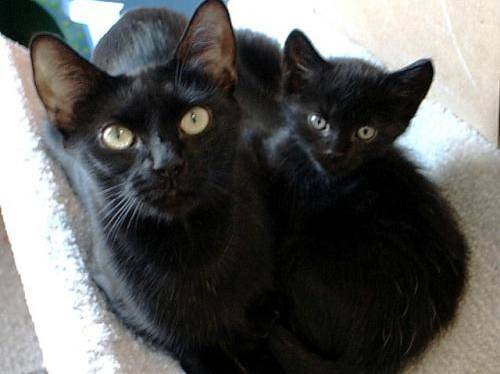

In [64]:
search_similar('https://i.pinimg.com/originals/18/59/a5/1859a5e8fbe435f89d58cd917c92cea4.jpg')